<a href="https://colab.research.google.com/github/kameda-yoshinari/DataAlgo2020/blob/master/DataAlgo2020_008(%EF%BC%91%E5%AF%BE%EF%BC%AE%E3%81%AE%E6%9C%80%E7%9F%AD%E7%B5%8C%E8%B7%AF%E5%95%8F%E9%A1%8C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.2. １対Ｎの最短経路問題

ここではある頂点を開始頂点としたときの最短経路問題とそれを解くDijkstraのアルゴリズムについて学ぶ．

**いつもの約束**  
１つのコードセルだけの実行は Ctrl + Enter．  
エディタで「インデント幅（スペース）は4で表示」「行番号を表示」「インデントガイドを表示」．  
挿入図は Google Colaboratory  以外では見れない可能性あり．  
内部では日本語はUTF-8で表現されている．


# 準備

インスタンスに接続し起動する．  
下記の手順でGoogle Driveをマウントする．  
マウント先に移動し，作業フォルダとする．  
これによって，インスタンスがリセットされてもGoogle Drive内にファイルが保存されるようにする．

In [0]:
!echo "Google Driveをマウントします"
from google.colab import drive 
drive.mount('/content/drive')

In [0]:
!echo "今回の作業用フォルダを作成しそこに移動します"
%cd /content/drive/My\ Drive/
%mkdir -p 202004_DataAlgo/DA2020_008
%cd       202004_DataAlgo/DA2020_008
!ls
!echo "日本時間表示"
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Japan /etc/localtime
!date

本節での説明には，グラフ6を利用する．  
頂点数は8．無向グラフ．ループなし．重みは全て正．  
プログラムの解析用に，グラフ7, グラフ8も用意しておく．



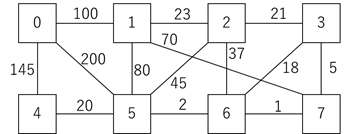

In [0]:
%%writefile graph6.h
// 8 nodes, undirected, no loop, positive weight.
// NC means no edges.
// NC will be treated as "inifinity" on searching the shortest path. 
#define N 8
#define NC 9999 // this big value means both no path and infinity 
int edge[N][N] = {
//     0   1   2   3   4   5   6   7
	{ NC,100, NC, NC,145,200, NC, NC}, // 0
	{100, NC, 23, NC, NC, 80, NC, 70}, // 1
	{ NC, 23, NC, 21, NC, 45, 37, NC}, // 2
	{ NC, NC, 21, NC, NC, NC, 18,  5}, // 3
	{145, NC, NC, NC, NC, 20, NC, NC}, // 4
	{200, 80, 45, NC, 20, NC,  2, NC}, // 5
	{ NC, NC, 37, 18, NC,  2, NC,  1}, // 6
	{ NC, 70, NC,  5, NC, NC,  1, NC}  // 7
};

In [0]:
%%writefile graph7.h
// 4 nodes, directed, positive weight.
// NC means no edges.
// NC will be treated as "inifinity" on searching the shortest path. 
#define N 4
#define NC 9999 // this big value means no path
int edge[N][N] = {
//     0   1   2   3
	{ NC, 10, NC, 40}, // 0
	{ NC, NC, NC, 20}, // 1
	{ NC, NC, NC, NC}, // 2
	{ NC, NC, NC, NC}, // 3
};

In [0]:
%%writefile graph8.h
// 12 nodes, directed, positive weight.
// NC means no edges.
// NC will be treated as "inifinity" on searching the shortest path. 
#define N 12
#define NC 9999 // this big value means no path
int edge[N][N] = {
    { 0, 4,NC,NC, 3,NC,NC,NC,NC,NC,NC,NC},
    { 4, 0, 1,NC,NC,NC, 2,NC,NC,NC,NC,NC},
    {NC, 1, 0, 1,NC,NC,NC, 2,NC,NC,NC,NC},
    {NC,NC, 1, 0,NC,NC,NC,NC,NC,NC,NC,NC},
    { 3,NC,NC,NC, 0, 1,NC,NC, 1,NC,NC,NC},
    {NC,NC,NC,NC, 1, 0, 2,NC,NC, 2, 3,NC},
    {NC, 2,NC,NC,NC, 2, 0,NC,NC,NC, 3,NC},
    {NC,NC, 2,NC,NC,NC,NC, 0,NC,NC,NC,NC},
    {NC,NC,NC,NC, 1,NC,NC,NC, 0,NC,NC,NC},
    {NC,NC,NC,NC,NC, 2,NC,NC,NC, 0,NC,NC},
    {NC,NC,NC,NC,NC, 3, 3,NC,NC,NC, 0, 1},
    {NC,NC,NC,NC,NC,NC,NC,NC,NC,NC, 1, 0}
};

# １対Ｎの最短経路問題を解くDijkstraのアルゴリズム

**内容**

グラフとして重み付き有向グラフを考える．辺に重みとして数値が付与されている．
本節では，辺の重みは正値とする．
隣接する頂点aと頂点bの間の辺の重みをedge(a,b)で表現する．edge(a,b)は正値である．  

最短経路問題とは，与えられた重み付き有向グラフにおいて，指定された２頂点間を結ぶ道を考える時，最も重みの軽い道の重みを求める問題である．ここでは，頂点Aから頂点Bへの「道」には，同じ頂点は高々一度しか現れないものとする．ある道（経路）が与えられた時，その辺の重みの合計のことを経路（道）の重み或いは経路値と呼ぶ．

指定された２頂点間に道がない場合は，その経路値は無限大として扱う．

解を示す道（経路）ももちろん求めるべきである．

一般に，指定された２頂点について最短経路問題を解く計算時間と，開始頂点を指定してその他すべての頂点への（１対Ｎの）最短経路問題を解く計算時間はオーダー表現において同じであるとされている．（到着頂点を指定してその他すべての頂点を開始頂点にした場合でも同じ．）

**Dijkstraのアルゴリズム**

１対Ｎの最短経路問題を解くアルゴリズムとして，Dijkstra（ダイクストラ）のアルゴリズムを学習する．

Dijkstraのアルゴリズムは，貪欲法(Greedy algorithm)の１つとして知られる．

>**（貪欲法）**
>
>貪欲法の定義の詳細は本授業では省くが，簡単に言えば，解を求める途中で，その時点で最適と思われる方に進む方法である．
>
>例えば，街で目的地の高い建物が見えているとき，その方向に向かって真っすぐ進む方法がこの一例として考えられる．途中に壁があったり一方通行があったりすると，真っすぐ進むのはかえって結果的に遠回りになるかもしれない．しかし，それはあとになってしかわからないことだと割り切ってその場では真っすぐ進むことはよくあるだろう．人間の普段の行動によく似ているとも言える．
>
>貪欲法に基づくアルゴリズムでは，一般には最適解を得る保証はない．しかしながら，Dijkstraのアルゴリズムは数少ない例外である．
すなわち，Disktraのアルゴリズムは貪欲法でありながら，このアルゴリズムによって最短経路問題の最適解が得られることが証明されている．

以下では，最短を最小と置き換えて説明する．

1. 開始頂点から開始頂点への経路値は0とする．開始頂点から他の頂点の経路値については全て無限大とする（これは現在たどり着けないという意味ではなく，経路値についてまだ全く未確認であるという状況を表していると考えると分かりやすいだろう）．
2. 全ての頂点を未処理頂点集合Uの要素とする．
3. Uの中で経路値が最小の頂点kを選ぶ．（1.の設定から，初めて3.に来たときは開始頂点が選ばれることになる．）
4. 頂点kをUから削除する．
5. Uの中で頂点kに隣接する頂点について，頂点kを経由して到達する経路値のほうが小さければ，その頂点の経路値を更新する．
6. 未処理頂点集合Uが空集合になるまで，3.から5.を繰り返す．
7. 各頂点の経路値がそのまま開始頂点からの最小経路値となる．

Dijkstraのアルゴリズムは直感的な解決方法に似ていると感じはしないだろうか．順を追って実際にグラフ6で処理を実行してみればその感覚はさらに強まるだろう．

グラフ6での処理進行については，次図を参照されたい．
図中において，頂点枠内の数字は経路値を示している．
三段になっている各小図は，上段が3.，中段が4.と5.の新しい経路値の計算まで，下段が5.の経路値の更新に相当している．
中段では，新しく計算できるようになった経路と頂点を破線で示し，その経路値を頂点枠中の下側に示している．5.で小さい方の値を選択することで下段の状態になる．
辺の表示が有向辺に切り替わるのは，経路値を実現する経路を示すためである．
開始頂点0から見て，曲線の外側が未処理頂点集合Uを表している．

**実装**

残念ながら，Dijkstraのアルゴリズムは，C言語での実装に不向きなものの一つである．

その理由は，処理に集合を用いていることである．C言語の仕様には集合を直接扱える構造がない．  
（深さ優先探索の時はスタック構造が関数呼び出しに埋め込まれていたことを思い出そう）

そのため，集合を扱う関数群を用意してから，アルゴリズムの実装に取り掛かるという２段構成が必要になる．

**備考（雑談）**

私が学生時代に諸君らと同じように初めてDiskstraのアルゴリズムを習った時，教えて下さった先生はfortran言語を使った数値解析が専門であった．
その先生が，"Dijkstra"と板書されたときにやおらこちらに向かって「すごくいい名前ですよね？気に入っているんです」とおっしゃられた．
何を言い出したのだろう，と不思議に思った．
すると，先生は，「名前に"i","j","k"がこの順に入っている．これはプログラミングの申し子のような名前ですごくいいと思うんです」と．
それから30年近く経つが，その時の先生のとても楽しそうな顔が今でも忘れられない．
ああ，本当にこの先生はこういうことが好きなのだな，大学の先生とはこういう方なのだな，と強く思ったことを今でも覚えている．
だからなんだと言われると困るが，不思議な縁で大学の教員となった今，こうしたことを伝えておこうと思うのである．
（プログラミングでループ変数は伝統的に i を用いる．これは iteration/繰り返し の頭文字である．２重ループ，３重ループとなると，それに続くアルファベットを使うのが伝統であるので，３重ループではi,j,kが順に使われることが多い．数値解析などでは多重ループがよく出てくるので，i,j,kを連続して使うことはままある）

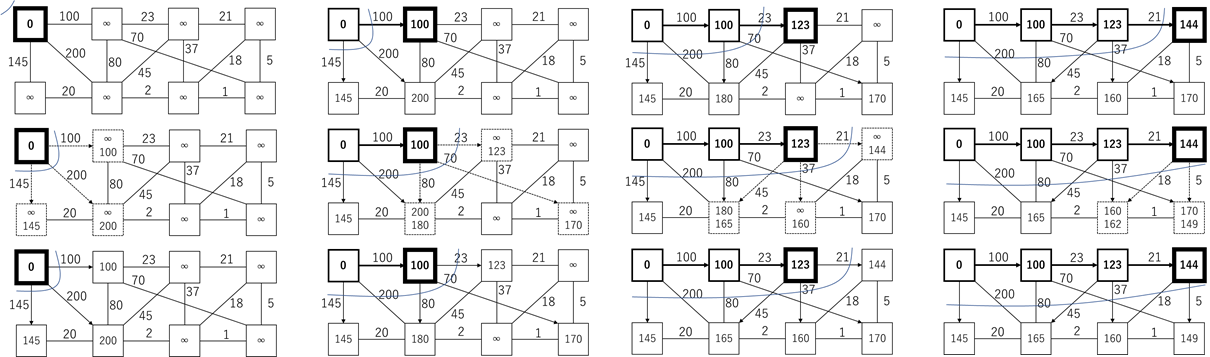

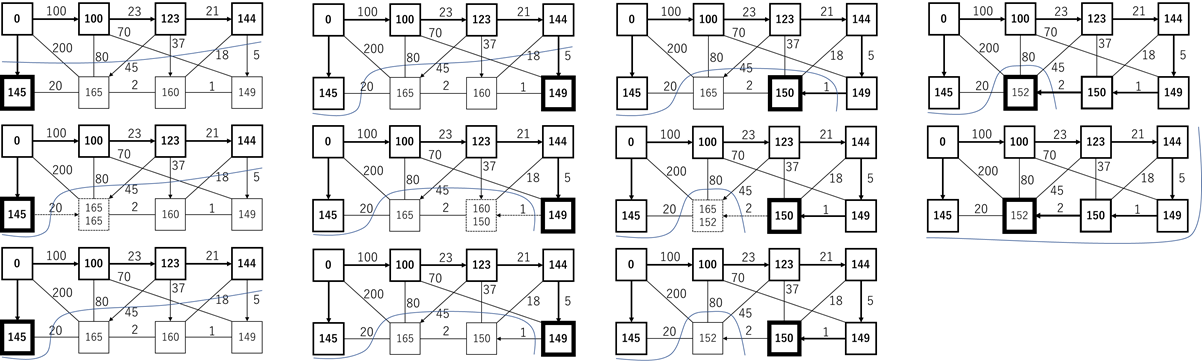

# Dijkstraのアルゴリズムに基づくプログラム

**目標**

正値重みの辺で構成される有向グラフにおいて，ある頂点を開始頂点としたときの各頂点への最小経路値とその経路を求めるＣプログラムを作成する．

**説明**

Dijkstraのアルゴリズム本体は一つのユーザ定義関数 find_shortest_diskstra() で実装する．集合操作を別ソースファイルで記述する．
集合操作については，これまでに学習した QueueLib / StackLib と同じ要領で SetLib として作成する．

トップダウンプログラミングに馴染めるよう，今回は SetLib_J.h を先に書き，必要なプログラムを実際に実装する形を取ってみよう．

1. SetLib_J.h ... 関数のプロトタイプ宣言．各関数に必要とされる集合操作を説明しておく．どのような集合操作が必要かは，Dijkstraのアルゴリズムを精査して抜き出す．
2. SetLib_J.c ... 各関数の実体を実装する．
3. shortest-dijkstra_J.c ... 引数を解析するmain()関数，上述のfind_shortest_dijkstra() の他，経路値情報を表示する関数も用意する．

**コード**

SetLib_J.h でプロトタイプ宣言を並べたあと，そのファイルをコピーして SetLib_J.c とし，関数名・引数に続いて実際にそれぞれの関数についてのプログラム記述していく形が取れれば，トップダウンプログラミングが出来ていると言えよう．

**備考**

集合操作にどのような関数が必要か見通すためには，Dijkstraのアルゴリズムを正確に理解できていることが必須である．

In [0]:
%%writefile SetLib_J.h
// Set management
// 2020/05 kameda[at]ccs.tsukuba.ac.jp

// １つの集合のみ扱う．
// その集合の要素は非負の整数とする．

// 集合の初期化
// 引数：確保する要素数
// 返値：成功...確保した整数配列のポインタ, 失敗...NULL
int *initset(int );

// 集合への追加
// 指定された（非負）整数を集合に追加する．
// 返値：成功 ... 指定された整数, 失敗 ... 負値
int addelement(int );

// 集合から要素vを削除
// 指定された整数を集合から削除する．
// 返値：成功 ... 指定された整数, 失敗 ... 負値
int deleteelement(int );

// 集合の要素一覧の入手
int obtainelementlist(int *, int );

// 集合の状態表示
int showset(void);

// 集合の全表示（通常意味はない）
int showallset(void);


In [0]:
%%writefile SetLib_J.c
// Set management
// 2020/05 kameda[at]ccs.tsukuba.ac.jp
#include <stdio.h> // printf()
#include <stdlib.h> // calloc()
#include "SetLib_J.h" // プロトタイプ宣言の整合確認

int *setU = NULL;  // 頂点集合 U を表す配列
int setsize = 0; // 集合 U の最大要素数
int numset = 0; // 集合 U の現在の要素数 (配列先頭から)

// 集合の初期化
// 引数：確保する要素数
// 返値：成功...確保した整数配列のポインタ, 失敗...NULL
int *initset(int n) {
	setU = calloc(n, sizeof(*setU));
	setsize = n;
	if (setU == NULL) {
		printf("【失敗】 %d要素分の集合用配列を確保できませんでした．\n", n);
		setsize = 0;
	}
	return setU;
}

// 集合への追加
// 指定された（非負）整数を集合に追加する．
// 返値：成功 ... 指定された整数, 失敗 ... 負値
int addelement(int v) {
    if (setU == NULL) {
        printf("【失敗】 集合が用意できていません．\n");
        return -1;
    } else if (numset >= setsize) {
        printf("【失敗】 %d要素確保してあった集合領域を使い果たしてしまいました．\n", setsize);
        return -2;
    }
    setU[numset] = v;
    numset++;
    return 0;
}

// 集合から要素vを削除
// 指定された整数を集合から削除する．
// 返値：成功 ... 指定された整数, 失敗 ... 負値

int deleteelement(int v) {
    int setindex = -1;
    int i;

    if (setU == NULL) {
        printf("【失敗】 集合が用意できていません．\n");
        return -1;
    } else if (numset <= 0) {
        printf("【報告】 空集合なので要素を取り出せません．\n");
        return -2;
    } else {
        // 集合配列内の要素vが存在する位置を探索
        for (i = 0; i < numset; i++) {
            if (setU[i] == v)
                setindex = i;
        }
        if (setindex < 0) {
            printf("【報告】要素%dが存在しませんでした．\n", v);
            return -3;
        }
    }

	// U: setU[0, ... ,numset-1] において setU[setindex] が抜けるので、配列 setU[]の端の setU[numset-1]を代入して端を捨てる
	setU[setindex] = setU[numset - 1];
	numset--;

    return v;
}

// 集合の要素一覧の入手
int obtainelementlist(int *array, int n) {
    int i;

    if (setU == NULL) {
        printf("【失敗】 集合が用意できていません．\n");
        return -1;
    } else if (n < numset) {
        printf("【失敗】 用意した配列が小さ過ぎます．%d, %d\n", n, numset);
        return -2;
    }

    for (i = 0; i < numset; i++) {
        array[i] = setU[i];
    }
 
    return numset;
}

// 集合の状態表示
int showset(void) {
    int i;

    if (setU == NULL) {
        printf("【失敗】 集合が用意できていません．\n");
        return -1;
    }

    printf("setsize = %d, number of elements = %d\n", setsize, numset);
    for (i = 0; i < numset; i++) {
        printf("%d ", setU[i]);
    }
    printf("\n");

    return numset;
}

// 集合の全表示（通常意味はない）
int showallset(void) {
    int i;

    if (setU == NULL) {
        printf("【失敗】 集合が用意できていません．\n");
        return -1;
    }

    printf("setsize = %d, number of elements = %d\n", setsize, numset);
    for (i = 0; i < setsize; i++) {
		if (i == numset)
			printf("| ");
        printf("%d ", setU[i]);
    }
    printf("\n");
    return setsize;
}

In [0]:
!gcc -Wall -c SetLib_J.c

In [0]:
%%writefile shortest-dijkstra_J.c
// Shortest path by Dijkstra
//    2020/05/30 kameda
#include <stdio.h> // printf()
#include <stdlib.h> // atoi()
#include "SetLib_J.h"
#include "graph6.h" // edge[][], N, NC

typedef struct {
	int cost; // 現時点でこの頂点に到達するのにかかると思われる最安コスト cost
	int from; // 最短経路利用時，この頂点には 頂点from から来る
} CostFrom;

CostFrom nodeinfo[N]; // 到着頂点i に対する最短経路情報

// 頂点状態の表示
void print_node_status(char *show_str, int show_v){
	int i;
	
	printf("%s at %d:", show_str, show_v);
	printf(" cost(");
	for (i = 0; i < N; i++)
 		if (nodeinfo[i].cost == NC) 
   			printf("--- ");
		else
			printf("%3d ", nodeinfo[i].cost);
	printf(") from(");
	for (i = 0; i < N; i++)
 		printf("%2d ", nodeinfo[i].from);
	printf(")\n");

	showset();
	return ;
}

// 始点 StartNode から 他の全ての頂点への最短路を探す
void find_shortest_dijkstra(int StartNode){
	int v; // 頂点
	int i;
	int restelements = 0; // 未処理の頂点数
	int restS[N]; // 未処理頂点のリスト（個数はrestelements）
	int min_node; // 経路が暫定最短となる頂点
	int min_cost; // その頂点min_nodeまでの暫定最短経路値
	
	// 集合 U に開始頂点以外を追加
	printf("Dijkstra: 集合を%d要素分確保します．\n", N);
	initset(N);
	for (v = 0; v < N; v++) {
		addelement(v);
		restelements++;
	}

	// 初期化
	// 開始頂点 StartNode
	// 開始頂点以外の初期解（コスト）は無限大(NC)
	printf("Dijkstra: 初期化します．\n");
	for (v = 0; v < N; v++) {
		if (v == StartNode){
			nodeinfo[v].cost = 0;
			nodeinfo[v].from = StartNode;
		} else {
			nodeinfo[v].cost = NC;  
			nodeinfo[v].from = -1; // どこから行くわけでもない	  
		}
	}

	// いよいよスタート
	print_node_status("Start", 0);
	while (restelements > 0) {
		  
	  	print_node_status("Loop ", restelements);

		// 未処理頂点集合を獲得
		obtainelementlist(restS, N);
		
		// 集合 U の中で、最小コストを与える頂点(min_node)を探す
		// 頂点(min_node)はsetU[]のmin_node_index番目の要素として格納されていることに注意
		// 探すにあたって、まずsetU[]の先頭要素を、暫定的に最小コストを与える頂点と仮定
		min_node = restS[0]; 
		min_cost = nodeinfo[min_node].cost; 
		for (i = 1; i < restelements; i++) {
			v = restS[i];
			if (nodeinfo[v].cost < min_cost) {
				min_node = v;
				min_cost = nodeinfo[v].cost;
			}
		}
		printf("未処理頂点集合内で最小の頂点 %d コスト %d\n",min_node, min_cost);

		// 未処理頂点集合から min_node を削除
		deleteelement(min_node);
		restelements--;

		// 未処理頂点集合を入手
		obtainelementlist(restS, N);

		// 未処理頂点集合において、新しく見つかった min_node 経由でコストが下がる場合はコストを書き換え
		// 未処理頂点集合のうち、 min_nodeからの経路があるものだけが検査対象
		for (i = 0; i < restelements; i++) {
			v = restS[i]; // 検査対象の頂点
			if (edge[min_node][v] > 0) {
				if (nodeinfo[min_node].cost + edge[min_node][v] < nodeinfo[v].cost) {
					nodeinfo[v].cost = nodeinfo[min_node].cost + edge[min_node][v];
					nodeinfo[v].from = min_node;
				}
			}
		}
	}

	// 目的地 v への最小コストとそこへ至る「最短経路」の表示
	for (v = 0; v < N; v++) {
		printf("To %2d : ", v);
		if (v == StartNode) {
			printf("----");
		} else if (nodeinfo[v].cost == NC) {
			printf("No path");
		} else {
			int s;
			printf("cost %3d : ", nodeinfo[v].cost);
			for (s = v; s != StartNode; s = nodeinfo[s].from)
				printf("%2d <- ", s);
			printf("%2d", StartNode);
		}
		printf("\n");
	}
}

int main(int argc, char *argv[]){
    int startnode = 0;

    if (argc == 1) {
        printf("指定がなかったので頂点0を開始頂点にします．\n");
        startnode = 0;
    } else if (argc == 2) {
        startnode = atoi(argv[1]);
        if (startnode < 0 || startnode >= N) {
            printf("不正な頂点指定だったので終了します．\n");
            return -1;
        }
    }

	find_shortest_dijkstra(startnode); // 開始頂点番号を引数にして最短経路探索を開始

	return 0;
}



コンパイルしてエラーが無いことを確認．

In [0]:
!gcc -Wall -c shortest-dijkstra_J.c

In [0]:
!gcc -Wall -o shortest-dijkstra_J shortest-dijkstra_J.o SetLib_J.o

実行．

In [0]:
!./shortest-dijkstra_J 0    

# 節末課題

1. 最短経路の表示の仕組み  
shortest_dijkstra プログラムにおいて，それぞれの頂点への最小経路値を実現する経路を表示する仕組みを説明せよ．
このとき，構造体CostFromのメンバ from に格納されている値について言及すること．


2. 計算量  
shortest_diskstra プログラムの時間計算量と空間計算量を議論せよ．

3. 重みが零の辺  
グラフ中に重みが0の辺があった場合，最短経路問題に与える影響について論ぜよ．


4. 閉路の実際上の扱い  
与えるグラフに閉路が存在してはならないが，実際には上記のプログラムに閉路が含まれるグラフを与えても実行すると結果が出てしまう．これは本プログラムがグラフの解釈を都合のよいように勝手に変えているからと考えることができる．  
それでは，本プログラムでは，閉路が存在するとき，それをどう解釈しているのか，説明を試みよ．

5. エラーハンドリング  
SetLibで定義された関数を使うときに，１か所を除いてエラーハンドリングをしていない．エラーハンドリングしている個所を示せ．他にエラーハンドリングすべき箇所を示せ．そのうちの１か所（最初）について，対策をした改変例を示せ．


6. SetLib関数群における高速化  
SetLibにおいて，集合の初期化を要素数Nで行った場合に，その要素を0からN-1に限定すると，SetLibの各関数を高速化することができる．deleteelement()関数を例に，時間計算量をO(N)からO(1)にする方策について示せ．


# 出典

筑波大学工学システム学類  
データ構造とアルゴリズム  
担当：亀田能成  
2020/06/07.

